# [RSNA 2023 Abdominal Trauma Detection](https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection)

> Detect and classify traumatic abdominal injuries

![](https://www.kaggle.com/competitions/52254/images/header)

# Idea:
* In this notebook will do inference for `Detect and classify traumatic abdominal injuries` from CT scans.
* Dicom images are saved to `512 x 512` without keeping aspect ratio. Modify `resize_dim` in config file to change them.
* Batch Size is chosen adaptly depending on the image_size, you can change it on the `inference` cell
* You can play with notebook by simply changing `tta` parameter in config.

# Notebooks
* CNN:
    * Train: [RSNA-ATD: CNN [TPU][Train]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-train/)
    * Infer: [RSNA-ATD: CNN [TPU][Infer]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-infer/)

# Logging:
* `v14` : Correction for prediction formatting. Order of `healthy` and `injured` was reversed. Thanks to [@coderrkj](https://www.kaggle.com/code/coderrkj/rsna-atd-cnn-tpu-infer-corrections) for noticing that.
* `v12` : Same as `v10` but with `float32` in prediction
* `v11` : Two models, no thresholding
* `v10` : One model, no threhsolding (LB: 0.81)
* `v09` : One model, thresholding for both single and multiclass (LB: 12+)

# Install Libraries

In [25]:
# conda install -c conda-forge pyyaml
# conda install -c conda-forge opencv
# pip install dicomsdl
# pip install python-gdcm
# pip install -U efficientnet
# pip install tensorflow-addons

# Import Libraries

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import yaml
import gc



from IPython import display as ipd
from glob import glob
from tqdm.notebook import tqdm

# Version Check

In [27]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfa:', tfa.__version__)

np: 1.26.0
pd: 2.1.3
sklearn: 1.3.2
tf: 2.10.0
tfa: 0.22.0


# Configuration

In [28]:
class CFG:
    debug         = True
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1 if debug else 0
    
    # device
    device = "GPU" # or "GPU"

    # seed for data-split, layer init, augs
    seed = 42 
    
    # which folds of ckpt to use
    num_folds = 1

    # dicom to png size
    resize_dim = 512
    
    # size of training image
    img_size = [512, 512]

    # augmentation
    augment   = True

    # scale-shift-rotate-shear
    transform = False
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = False
    vflip = False

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'exp' # cosine

    # dropout
    drop_prob   = 0.0
    drop_cnt    = 10
    drop_size   = 0.08

    # pixel-augment
    pixel_aug = False
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # threshold
    thr = 0.50
    
    # test-time augs
    flip_model = False
    tta = 1
    
    # target column
    target_col  = ['bowel_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']

# Reproducibility

In [29]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Device Configs
This notebook is compatible for **remote-tpu**, **local-tpu**, **multi-gpu** and **single-gpu**. Simple change to `device="TPU"` for **remote-tpu** and `device="TPU-1VM"` for **local-tpu** and finally, `device="GPU"` for single or multi-gpu.

In [30]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-1VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using CPU
REPLICAS: 1


# Meta Data

In [31]:
# define the path to my data
BASE_PATH = 's:/Capston/data'
IMG_DIR = 's:/tmp/Dataset/rsna-atd'
STRIDE = 10 # take one patient after each (STRIDE - 1) patients

## Test Paths

In [32]:
# Load metadata from CSV file
meta_df = pd.read_csv(f'{BASE_PATH}/test_series_meta.csv')

# Construct the full path to DICOM folders using base path, patient ID, and series ID
meta_df['dicom_folder'] = BASE_PATH + '/test_images' + '/' + meta_df.patient_id.astype(str) + '/' + meta_df.series_id.astype(str)

# Convert the 'dicom_folder' column to a list
test_folders = meta_df.dicom_folder.tolist()

# Initialize an empty list to store the paths to DICOM files
test_paths = []

# Loop through each folder in 'test_folders'
for folder in tqdm(test_folders):
    # Get all DICOM file paths in the folder, sort them, and apply striding
    folder_paths = sorted(glob(os.path.join(folder, '*dcm')))[::STRIDE]
    
    # Normalize file paths by replacing backslashes with forward slashes and removing double slashes
    folder_paths = [path.replace('\\', '/').replace('//', '/') for path in folder_paths]
    
    # Append the normalized paths to the 'test_paths' list
    test_paths += folder_paths

  0%|          | 0/6 [00:00<?, ?it/s]

In [33]:
# Perform a quick verification on the 'dicom_folder' column
meta_df['dicom_folder'].head()

0      s:/Capston/data/test_images/48843/295
1    s:/Capston/data/test_images/48843/62825
2    s:/Capston/data/test_images/50046/24574
3    s:/Capston/data/test_images/50046/60658
4    s:/Capston/data/test_images/63706/39279
Name: dicom_folder, dtype: object

## Test Dataframe

In [34]:
test_df = pd.DataFrame(test_paths, columns=["dicom_path"])
test_df['patient_id'] = test_df.dicom_path.map(lambda x: x.split('/')[-3]).astype(int)
test_df['series_id'] = test_df.dicom_path.map(lambda x: x.split('/')[-2]).astype(int)
test_df['instance_number'] = test_df.dicom_path.map(lambda x: x.split('/')[-1].replace('.dcm','')).astype(int)

test_df['image_path'] = f'{IMG_DIR}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str)\
                    + '/' + test_df.instance_number.astype(str) +'.png'

print('Test:')
print(f'# Size: {len(test_df)}')
display(test_df.head())

Test:
# Size: 3


,dicom_path,patient_id,series_id,instance_number,image_path
0,s:/Capston/data/test_images/48843/62825/30.dcm,48843,62825,30,s:/tmp/Dataset/rsna-atd/test_images/48843/6282...
1,s:/Capston/data/test_images/50046/24574/30.dcm,50046,24574,30,s:/tmp/Dataset/rsna-atd/test_images/50046/2457...
2,s:/Capston/data/test_images/63706/39279/30.dcm,63706,39279,30,s:/tmp/Dataset/rsna-atd/test_images/63706/3927...


# Check If Data Exist?

In [35]:
tf.io.gfile.exists(test_df.dicom_path.iloc[0])

True

## Test Ditribution

In [36]:
print('test_files:',test_df.shape[0])

test_files: 3


# DICOM to PNG

In [37]:
# Set my desire directory
os.chdir('s:/Capston/data')
os.getcwd()

's:\\Capston\\data'

## Create Directory

In [38]:
os.makedirs('/tmp/Dataset/rsna-atd', exist_ok = True)
os.makedirs('/tmp/dataset/rsna-atd/train_images', exist_ok = True)
os.makedirs('/tmp/dataset/rsna-atd/test_images', exist_ok = True)

## Dicom Utils

In [56]:
import cv2
import pydicom

def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

def read_xray(path, fix_monochrome = True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def resize_and_save(file_path):
    img = read_xray(file_path)
    h, w = img.shape[:2]  # orig hw
    img = cv2.resize(img, (CFG.resize_dim, CFG.resize_dim), cv2.INTER_LINEAR)
    img = (img * 255).astype(np.uint8)
    
    sub_path = file_path.split("/",3)[-1].split('.dcm')[0] + '.png'
    infos = sub_path.split('/')
    # sub_path = file_path.split("/",4)[-1].split('.dcm')[0] + '.png'
    # infos = sub_path.split('/')
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace('.png','')
    new_path = os.path.join(IMG_DIR, sub_path)
    os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)
    cv2.imwrite(new_path, img)
    return 

## Conversion

In [57]:
%%time
from joblib import Parallel, delayed
file_paths = test_df.dicom_path.tolist()
_ = Parallel(n_jobs=2,backend='threading')(delayed(resize_and_save)(file_path)\
                                                  for file_path in tqdm(file_paths, leave=True, position=0))
del _; gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

['test_images', '48843', '62825', '30.png']
['test_images', '50046', '24574', '30.png']
['test_images', '63706', '39279', '30.png']
CPU times: total: 234 ms
Wall time: 776 ms


96

# Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

In [59]:
def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    #rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
#     c1   = tf.math.cos(rotation)
#     s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
#     rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
#                                    -s1,  c1,   zero, 
#                                    zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                               zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    

    return  K.dot(shear_matrix,K.dot(zoom_matrix, shift_matrix)) #K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))                  

def transform(image, DIM=CFG.img_size):#[rot,shr,h_zoom,w_zoom,h_shift,w_shift]):
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]
    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rot = CFG.rot * tf.random.normal([1], dtype='float32')
    shr = CFG.shr * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    w_shift = CFG.wshift * tf.random.normal([1], dtype='float32') 
    
    transformation_matrix=tf.linalg.inv(get_mat(shr,h_zoom,w_zoom,h_shift,w_shift))
    
    flat_tensor=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)
    
    image=tfa.image.transform(image,flat_tensor, fill_mode=CFG.fill_mode)
    
    rotation = math.pi * rot / 180.
    
    image=tfa.image.rotate(image,-rotation, fill_mode=CFG.fill_mode)
    
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]
    image = tf.reshape(image, [*DIM, 3])    
    return image

def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

#     image = tf.reshape(image,[*DIM,3])
    return image

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [60]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3, dtype=tf.uint8)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        img = transform(img,DIM=dim) if CFG.transform else img
        img = tf.image.random_flip_left_right(img) if CFG.hflip else img
        img = tf.image.random_flip_up_down(img) if CFG.vflip else img
        if CFG.pixel_aug:
            img = tf.image.random_hue(img, CFG.hue)
            img = tf.image.random_saturation(img, CFG.sat[0], CFG.sat[1])
            img = tf.image.random_contrast(img, CFG.cont[0], CFG.cont[1])
            img = tf.image.random_brightness(img, CFG.bri)
        img = dropout(img, DIM=dim, PROBABILITY = CFG.drop_prob, CT = CFG.drop_cnt, SZ = CFG.drop_size)
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [61]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
        tars = tf.concat(tars,axis=-1).numpy()
    else:
        imgs = batch
        tars = None
    
    plt.figure(figsize=(size*5, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{tars[img_idx].round(2)}', fontsize=12)
        img = imgs[img_idx,]
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

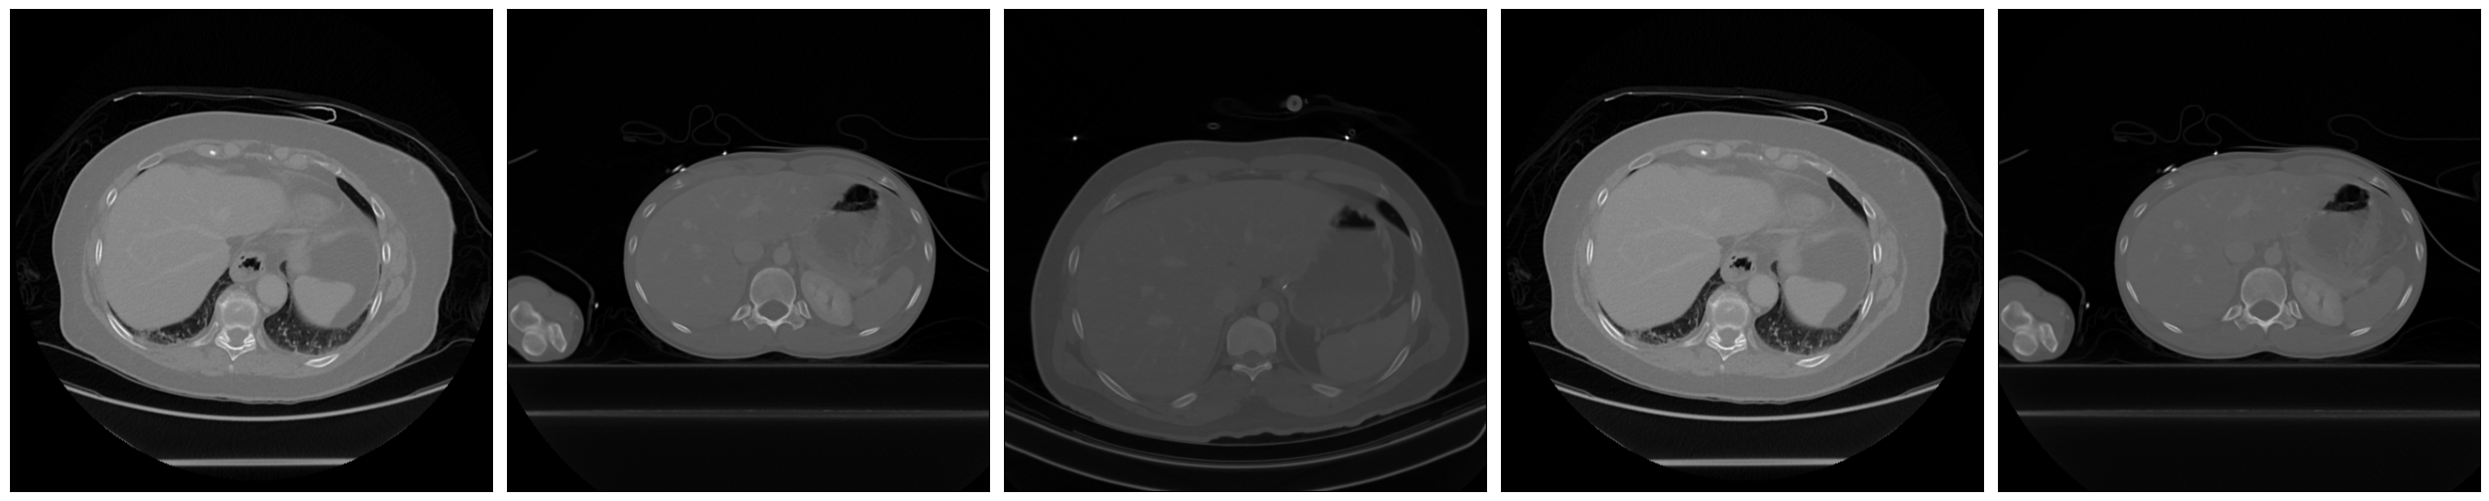

In [62]:
fold_df = test_df.copy()
paths  = fold_df.image_path.tolist()
labels = None
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=True)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# Model Configs

In [71]:
CKPT_DIRS = [
    ([512, 512], 'S:/Capston/data/model'),
]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.num_folds]
    if len(paths)==0:
        print('no model found for :',ckpt_dir)
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[512, 512], ['S:/Capston/data/model\\fold-0.h5']]]

# Utility

In [72]:
def mc_proc(pred):
    argmax = np.argmax(pred, axis=1).astype('uint8')
    one_hot = tf.keras.utils.to_categorical(argmax, num_classes=3)
    return one_hot.astype('uint8')

def sc_proc(pred, thr=0.5):
    proc_pred = (pred > thr).astype('uint8')
    return proc_pred

def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2 + 2 + 3*3), dtype=np.uint8)

    # bowel, extravasation
    proc_pred[:, 0] = sc_proc(pred[:, 0])
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = sc_proc(pred[:, 1])
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = mc_proc(pred[:, 2:5])
    proc_pred[:, 7:10] = mc_proc(pred[:, 5:8])
    proc_pred[:, 10:13] = mc_proc(pred[:, 8:11])

    return proc_pred

def post_proc_v2(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype='float32')

    # bowel, extravasation
    proc_pred[:, 0] = 1 - pred[:, 0] # bowel-healthy
    proc_pred[:, 1] = pred[:, 0] # bowel-injured
    proc_pred[:, 2] = 1 - pred[:, 1] # extra-healthy
    proc_pred[:, 3] = pred[:, 1] # extra-injured
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

# Inference

In [73]:
# Getting unique patient IDs from test dataset
patient_ids = test_df['patient_id'].unique()

# Initializing array to store predictions
patient_preds = np.zeros(shape=(len(patient_ids), 2*2 + 3*3), dtype='float32')

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    # Query the dataframe for a particular patient
    patient_df = test_df.query("patient_id == @patient_id")
    
    # Initializing model predictions array
    model_preds = np.zeros(shape=(1, 11), dtype=np.float32)
    
    print("="*25)
    print(f"   Patient ID: {patient_id}")
    print("="*25)
    
    # Iterating over each model
    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):
        
        # Getting image paths for a patient
        patient_paths = patient_df.image_path.tolist()

        # Setting batch size based on number of patient paths and dimension of image
        dim = np.prod(img_size)**0.5
        if dim >= 1024:
            CFG.batch_size = REPLICAS * int(4 * 2)
        elif dim >= 768:
            CFG.batch_size = REPLICAS * int(16 * 2)
        elif dim >= 640:
            CFG.batch_size = REPLICAS * int(28 * 2)
        else:
            CFG.batch_size = REPLICAS * int(32 * 2)
            
        # Clip batch_sizs to min
        min_bs = 2**np.floor(np.log2(len(patient_paths)))
        CFG.batch_size = min(min_bs, CFG.batch_size)

        # Building dataset for prediction
        dtest = build_dataset(
            patient_paths, 
            batch_size=CFG.batch_size, repeat=True, 
            shuffle=False, augment=CFG.tta > 1, cache=False,
            decode_fn=build_decoder(with_labels=False, target_size=img_size),
            augment_fn=build_augmenter(with_labels=False, dim=img_size)
        )
        
        # Iterating over each fold
        for fold_path in fold_paths:
            with strategy.scope():
                # Loading a model from a fold path
                model = tf.keras.models.load_model(fold_path, compile=False)
            
            # Predicting with the model
            pred = model.predict(dtest, steps = CFG.tta * len(patient_paths) / CFG.batch_size, verbose=1)
            pred = np.concatenate(pred, axis=-1).astype('float32') # reducing memory footprint
            pred = pred[:CFG.tta * len(patient_paths), :]
            pred = np.mean(pred.reshape(CFG.tta, len(patient_paths), 11), axis=0)
            pred = np.max(pred, axis=0) # taking max prediction of all ct scans for a patient
            
            # Store model's prediction
            model_preds += pred / (len(fold_paths)*len(MODEL_CONFIGS))
            
            # Deleting variables to free up memory
            del model, pred; gc.collect()
            
            print('\n')
        
        del dtest, patient_paths; gc.collect()
            
    # Adding processed predictions to patient_preds
    patient_preds[pidx, :] += post_proc_v2(model_preds)[0]
    
    del model_preds; gc.collect()

print("Prediction Done!")

Patients :   0%|          | 0/3 [00:00<?, ?it/s]

   Patient ID: 48843
1/1 [==============================] - 2s 2s/step


   Patient ID: 50046
1/1 [==============================] - 2s 2s/step


   Patient ID: 63706
1/1 [==============================] - 3s 3s/step


Prediction Done!


# Submission

In [74]:
# Create Submission
pred_df = pd.DataFrame({'patient_id':patient_ids,})
pred_df[CFG.target_col] = patient_preds.astype('float32')

# Align with sample submission
sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[['patient_id']]
sub_df = sub_df.merge(pred_df, on='patient_id', how='left')

# Store submission
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

ValueError: Columns must be same length as key